# P1

In [1]:
import numpy as np
import keras
import time
import os
import cv2
import math
from PIL import Image
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from matplotlib import pyplot as plt

# P2

In [2]:

train_path = 'data/train/'
valid_path = 'data/valid/'

batch_size = 32

# Création des générateurs avec augmentation de données pour l'entraînement

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,        # Normalisation
    rotation_range=20,        # Rotation aléatoire
    width_shift_range=0.2,    # Décalage horizontal
    height_shift_range=0.2,   # Décalage vertical
    shear_range=0.2,          # Transformation en cisaillement
    zoom_range=0.2,           # Zoom aléatoire
    horizontal_flip=True      # Inversion horizontale
)


# Générateur de validation
valid_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

# Récupération des images pour la phase d'entrainement
train_batches = train_datagen.flow_from_directory(
    train_path,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'  # Classification Binaire : car / not_car
)

# Récupération des images pour la phase de test
valid_batches = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(100, 100),
    batch_size=batch_size,
    class_mode='binary'
)

# Vérification des indices de classe
print(train_batches.class_indices)  # Devrait afficher {'car': 0, 'not_car': 1} ou l'inverse


Found 418 images belonging to 2 classes.
Found 418 images belonging to 2 classes.
{'car': 0, 'not_car': 1}


In [3]:
# Définition du nombre d'itérations nécessaires pour parcourir l'intégralité de notre jeu de données lors d'une époque.
# Pour phase d'entrainement
steps_train = train_batches.samples // train_batches.batch_size

In [4]:
# Définition du nombre d'itérations nécessaires pour parcourir l'intégralité de notre jeu de données lors d'une époque.
# Pour phase de test
steps_valid = valid_batches.samples // valid_batches.batch_size

In [5]:
print(f"Nombre total d'images dans le train set : {train_batches.samples}")
print(f"Nombre total d'images dans le valid set : {valid_batches.samples}")


Nombre total d'images dans le train set : 418
Nombre total d'images dans le valid set : 418


In [6]:
cls_train = train_batches.classes
cls_test =  valid_batches.classes
class_names = list(train_batches.class_indices.keys())
class_names

['car', 'not_car']

In [7]:
def path_join(dirname, filenames):
    # Joindre les noms de fichiers au chemin du répertoire
    return [os.path.join(dirname, filename) for filename in filenames]

image_paths_train = path_join(train_path, train_batches.filenames)
image_paths_test = path_join(valid_path, valid_batches.filenames)

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Créer une figure avec des sous-graphiques (sub-plots).
    fig, axes = plt.subplots(3, 3)

    # Ajuster l'espacement vertical.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Type d'interpolation.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # Il peut y avoir moins de 9 images, s'assurer que cela ne plante pas.
        if i < len(images):
            # Afficher l'image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Nom de la classe vraie.
            cls_true_name = class_names[cls_true[i]]

            # Afficher les classes vraies et prédites.
            if cls_pred is None:
                xlabel = "Vrai : {0}".format(cls_true_name)
            else:
                # Nom de la classe prédite.
                cls_pred_name = class_names[cls_pred[i]]
                xlabel = "Vrai : {0}\nPrédit : {1}".format(cls_true_name, cls_pred_name)
            # Afficher les classes comme étiquette sur l'axe des x.
            ax.set_xlabel(xlabel)
        # Supprimer les ticks du graphique.
        ax.set_xticks([])
        ax.set_yticks([])

    # Assurer que le graphique est bien affiché avec plusieurs graphiques
    # dans une seule cellule de Notebook.
    plt.show()

def load_images_custom(image_paths):
    # Charger les images depuis le disque.
    images = [plt.imread(path) for path in image_paths]
    # Convertir en tableau numpy et le retourner.
    return np.asarray(images)

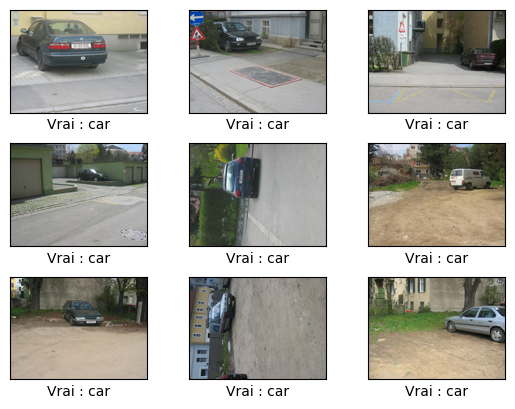

In [8]:
# Charger les premières images de l'ensemble d'entraînement.
images = load_images_custom(image_paths=image_paths_train[0:9])

# Obtenir les classes vraies pour ces images.
cls_true = cls_train[0:9]

# Afficher les images et les étiquettes en utilisant notre fonction d'aide ci-dessus.
plot_images(images=images, cls_true=cls_true, smooth=True)


# P3

In [9]:
# Définition d'un modèle CNN simple
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Sortie binaire
])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Résumé du modèle
model.summary()


/Users/atsug0/.pyenv/versions/3.12.0/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,333,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353,217 (16.61 MB)

 Trainable params: 4,353,217 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

# P4

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.6416 - loss: 0.6473 - val_accuracy: 0.5837 - val_loss: 0.6439
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.5645 - loss: 0.6929 - val_accuracy: 0.5909 - val_loss: 0.6265
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6389 - loss: 0.6499 - val_accuracy: 0.7775 - val_loss: 0.5762
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7107 - loss: 0.6008 - val_accuracy: 0.7847 - val_loss: 0.5271
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7475 - loss: 0.5593 - val_accuracy: 0.8278 - val_loss: 0.4967
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6898 - loss: 0.5789 - val_accuracy: 0.8325 - val_loss: 0.4622
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.7477 - loss: 0.5443 - val_accuracy: 0.7321 - val_loss: 0.5401
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7574 - loss: 0.5173 - val_accurac

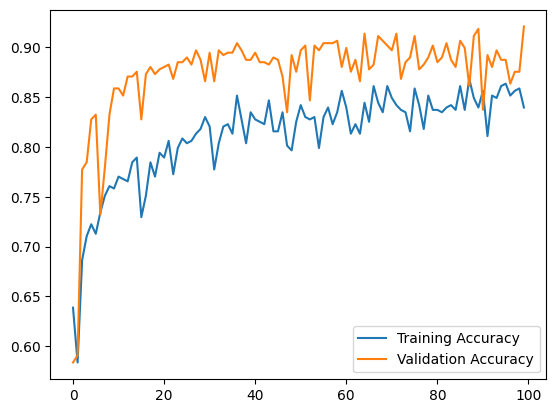

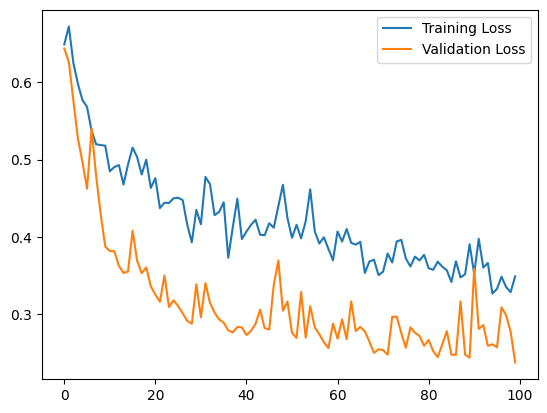

Le modèle a été entraîné en 145.37 secondes.


In [18]:
# Callbacks
start = time.time()



history = model.fit(train_batches, validation_data=valid_batches, epochs=100, verbose=1)

# Tracer les courbes d'entraînement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


end = time.time()

print(f"Le modèle a été entraîné en {end - start:.2f} secondes.")

In [10]:
end = time.time()

In [11]:
print ("Model took %0.2f seconds to train"%(end - start))
result = model.evaluate(valid_batches, steps=1)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Model took 234.02 seconds to train
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9062 - loss: 0.2331
Test-set classification accuracy: 90.62%


# P5

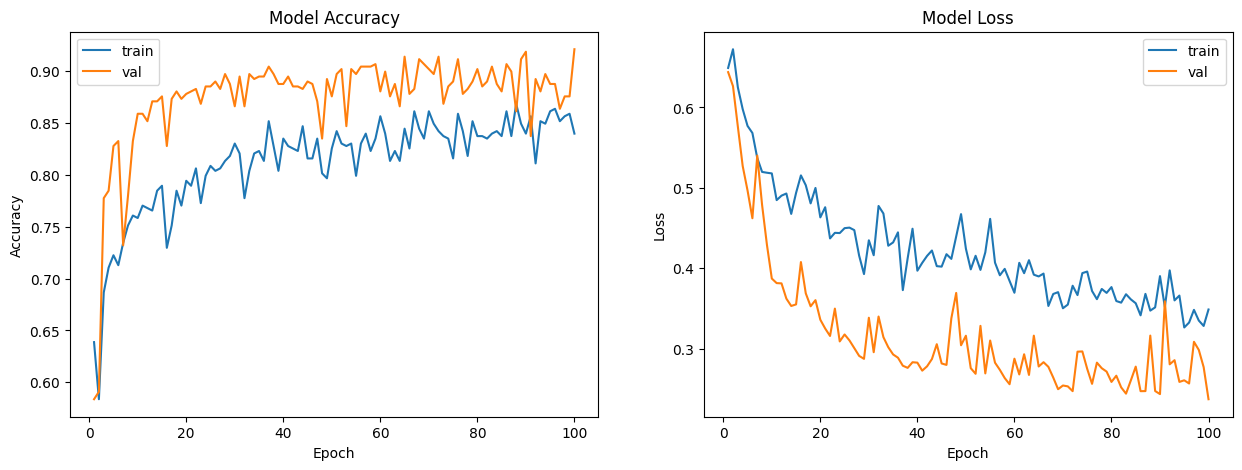

In [22]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    #axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    #axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

plot_model_history(history)

# P6

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


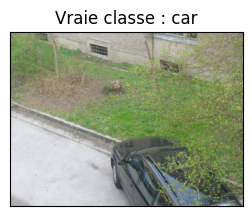

Prédiction : C'est une voiture avec 83.08% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


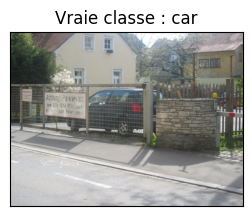

Prédiction : C'est une voiture avec 92.82% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


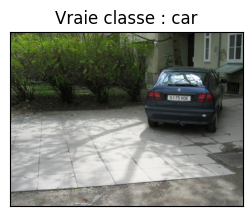

Prédiction : C'est une voiture avec 85.15% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


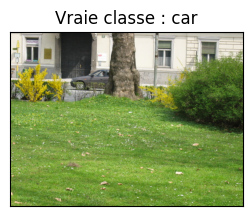

Prédiction : C'est une voiture avec 98.12% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


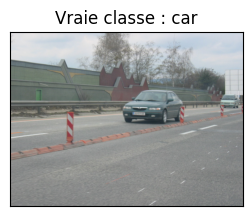

Prédiction : C'est une voiture avec 92.17% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


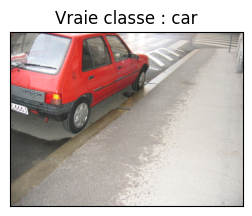

Prédiction : Ce n'est pas une voiture avec 50.02% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


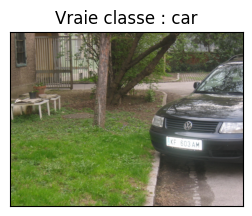

Prédiction : C'est une voiture avec 92.09% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


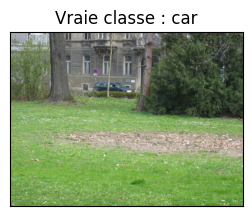

Prédiction : C'est une voiture avec 96.31% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


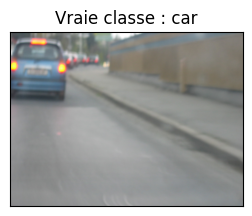

Prédiction : C'est une voiture avec 89.88% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


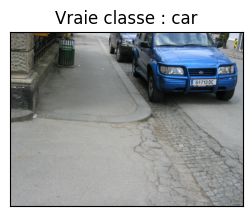

Prédiction : C'est une voiture avec 95.76% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


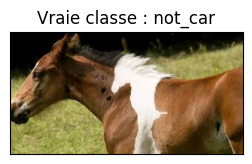

Prédiction : Ce n'est pas une voiture avec 99.38% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


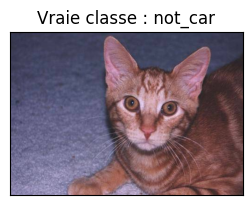

Prédiction : Ce n'est pas une voiture avec 97.54% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


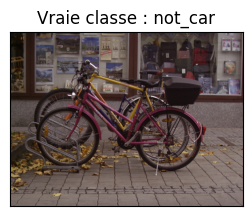

Prédiction : Ce n'est pas une voiture avec 89.93% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


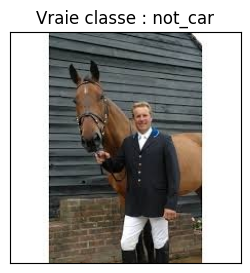

Prédiction : Ce n'est pas une voiture avec 95.15% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


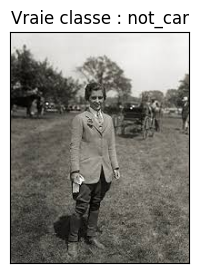

Prédiction : C'est une voiture avec 69.41% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


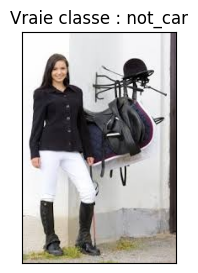

Prédiction : Ce n'est pas une voiture avec 97.69% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


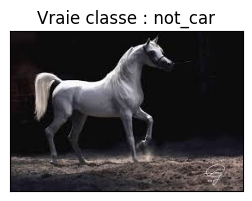

Prédiction : Ce n'est pas une voiture avec 99.48% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


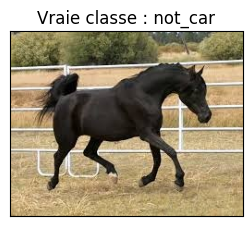

Prédiction : Ce n'est pas une voiture avec 95.28% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


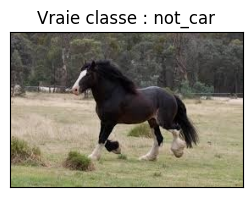

Prédiction : Ce n'est pas une voiture avec 91.97% de confiance
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


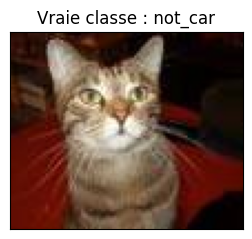

Prédiction : Ce n'est pas une voiture avec 99.40% de confiance


In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob  # Pour récupérer plusieurs fichiers à partir de dossiers

# Définir les chemins des images
car_images = glob.glob('data/valid/car/*')
not_car_images = glob.glob('data/valid/not_car/*')

# Sélectionner 10 images aléatoires de chaque classe
np.random.seed(42)  # Fixer la seed pour des tests reproductibles
selected_car_images = np.random.choice(car_images, 10, replace=False)
selected_not_car_images = np.random.choice(not_car_images, 10, replace=False)

# Combiner les chemins pour itérer
test_images = list(selected_car_images) + list(selected_not_car_images)
labels = ['car'] * 10 + ['not_car'] * 10  # Etiquettes pour les résultats attendus

# Fonction pour prédire et afficher les résultats
def predict_and_display(images, labels):
    for i, (img_path, label) in enumerate(zip(images, labels)):
        # Lire et préparer l'image
        img = cv2.imread(img_path)
        img_resized = cv2.resize(img, (100, 100))
        img_normalized = img_resized / 255.0  # Normalisation
        img_input = np.reshape(img_normalized, [1, 100, 100, 3])  # Ajouter la dimension batch

        # Prédire avec le modèle
        predic = model.predict(img_input)

        # Afficher l'image
        plt.figure(figsize=(3, 3))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convertir de BGR à RGB pour matplotlib
        plt.xticks([]), plt.yticks([])  # Supprimer les ticks de l'axe
        plt.title(f"Vraie classe : {label}")
        plt.show()

        # Afficher le résultat de la prédiction
        if predic[0][0] > 0.5:
            print(f"Prédiction : Ce n'est pas une voiture avec {predic[0][0] * 100:.2f}% de confiance")
        else:
            print(f"Prédiction : C'est une voiture avec {(1 - predic[0][0]) * 100:.2f}% de confiance")

# Tester le modèle sur les images sélectionnées
predict_and_display(test_images, labels)
